The [OECD gender wage gap dataset](https://stats.oecd.org/index.aspx?queryid=54751) shows the gender wage gap value of a number

of countries for the first and ninth income deciles for the years 2000, 2005, and 2010-2018. OECD defines the gender wage gap

value for a given country and given income decile as the percent to which the median male income is greater than the median

female income. In this Jupyter Notebook file, we will use MySQL and the PyMySQL and Pandas modules from Python to extract from

and analyze this OECD dataset. Specifically, we will first edit the dataset, given as a CSV file, on the aforementioned OECD 

website, by removing duplicate columns and empty columns, to make loading the CSV into MySQL possible as well as faster. Then,

we will use MySQL to efficiently extract and create optimally-formatted tables from the OECD gender gap dataset, and we will 

also use MySQL to compute, for each country in the dataset and for each of the first and ninth income deciles separately, the

average gender wage gap value over the seven years 2000, 2005, and 2010-2018, as well as the mean and population standard 

deviation of these average values, separated by income decile; population standard deviation will be more insightful than

sample standard deviation as there are only 196 countries in the world, all of which are known, so we will not need to make

inferences about countries not contained in this OECD gender wage gap dataset. We will then use the Pandas module from Python

to create Pandas dataframes from our MySQL tables; we will use these dataframes to cleanly show the mean and standard deviation

of the average gender wage gap values, separated by income decile, as well as a bar chart of the average wage gender gap 

values, again separated by income decile. We will need the PyMySQL module from Python to create an interface that will allow

Python to connect to a MySQL database server.

In [1]:
# Import the PyMySQL and Pandas modules from Python
import pymysql
import pandas as pd

In [2]:
# First create the table Gender_Wage_Gap_Table (we will run all the Python functions in this file in the order they were made).
# All the Python functions take in a connection from Python to MySQL.
def create_Gender_Wage_Gap_Table(connection):
    cursor = connection.cursor()
    cursor.execute("""CREATE TABLE IF NOT EXISTS Gender_Wage_Gap_Table
                      (COU VARCHAR(4) NOT NULL, Country VARCHAR(20) NOT NULL, IND VARCHAR(6) NOT NULL, 
                      Indicator VARCHAR(38) NOT NULL, Sex VARCHAR(11) NOT NULL, 
                      AGE VARCHAR(5) NOT NULL, `Age Group` VARCHAR(5) NOT NULL, 
                      Time INT NOT NULL, `PowerCode Code` VARCHAR(1) NOT NULL, PowerCode VARCHAR(5) NOT NULL,
                      `Value` DECIMAL NOT NULL);""")
    connection.commit()
    cursor.close()

In [3]:
# Load the OECD gender wage gap csv into Gender_Wage_Gap_Table
def load_csv_into_table(connection):
    cursor = connection.cursor()
    cursor.execute("""LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 5.6/data/Gender_Wage_Gap_Table.csv'
                      INTO TABLE Gender_Wage_Gap_Table 
                      FIELDS TERMINATED BY ','
                      LINES TERMINATED BY '\n'
                      IGNORE 1 ROWS;""")
    connection.commit()
    cursor.close()

In [4]:
# Now we will create a Pandas dataframe which will consist of the (abbreviated) names of the countries and the averages of 
# their respective gender wage gap values throughout the years for each decile. We will also return, for each decile, the mean 
# and population standard deviation of the average gender wage gap values.
def get_dataframes(connection): 
    cursor = connection.cursor()
    
    # Create table for first decile
    cursor.execute("""CREATE TABLE IF NOT EXISTS First_Decile_Table AS
                      SELECT COU, AVG(`Value`) AS `First Decile` 
                      FROM Gender_Wage_Gap_Table WHERE Indicator = 'Gender wage gap at 1st decile (bottom)' 
                      GROUP BY COU;""")
    
    # Compute mean and population standard deviation of first decile average values
    first_decile_mean_and_std = pd.read_sql("""SELECT AVG(`First Decile`) 
                                               AS `Mean of First Decile Average Gender Wage Gap Values`, 
                                               STD(`First Decile`) 
                                               AS `Standard Deviation of First Decile Average Gender Wage Gap Values`
                                               FROM First_Decile_Table;""", con = connection)
    
    # Create table for ninth decile
    cursor.execute("""CREATE TABLE IF NOT EXISTS Ninth_Decile_Table AS 
                      SELECT COU, AVG(`Value`) AS `Ninth Decile` 
                      FROM Gender_Wage_Gap_Table 
                      WHERE Indicator = 'Gender wage gap at 9th decile (top)'
                      GROUP BY COU;""")
    
    # Compute mean and population standard deviation of first decile average values
    ninth_decile_mean_and_std = pd.read_sql("""SELECT AVG(`Ninth Decile`) 
                                               AS `Mean of Ninth Decile Average Gender Wage Gap Values`, 
                                               STD(`Ninth Decile`) 
                                               AS `Standard Deviation of Ninth Decile Average Gender Wage Gap Values`
                                               FROM Ninth_Decile_Table;""", con = connection) 
    
    # Create table consisting of the average gender gap values of each country, separated by income decile
    df = pd.read_sql_query("""SELECT First_Decile_Table.COU, 
                              First_Decile_Table.`First Decile`,
                              Ninth_Decile_Table.`Ninth Decile`
                              FROM First_Decile_Table 
                              LEFT JOIN Ninth_Decile_Table
                              ON First_Decile_Table.COU = Ninth_Decile_Table.COU
                              ORDER BY First_Decile_Table.COU;""", con = connection, index_col = 'COU')
    
    # Gender_Wage_Gap_Table, First_Decile_Table, and Ninth_Decile table are no longer needed, so we drop all three of them
    cursor.execute("DROP TABLE Gender_Wage_Gap_Table;")
    cursor.execute("DROP TABLE First_Decile_Table;")
    cursor.execute("DROP TABLE Ninth_Decile_Table;")
    
    cursor.close()
    
    return df, first_decile_mean_and_std, ninth_decile_mean_and_std

In [5]:
# Finally, we will use the dataframe df from get_dataframes() to plot a bar graph of average gender wage gap value versus 
# country for the two deciles, and we will also show the mean and standard deviation of the average gender wage gap values. We 
# will need to use the Python functions from the previous columns in order to do all of this. We will run the create_bar_graph()
# function in the next cell.
def create_bar_graph():
    # Use PyMySQL to connect from Python to MySQL
    connection = pymysql.connect(
        host = 'localhost',
        user = 'root', 
        password = 'pwd',
        db = 'my_db_for_gender_data',
        )
    
    # Create a MySQL table, then load the OECD gender wage gap dataset into the MySQL table, then obtain the necessary
    # statistics as well as a Pandas dataframe from the MySQL table
    create_Gender_Wage_Gap_Table(connection)
    load_csv_into_table(connection)  
    df, first_decile_mean_and_std, ninth_decile_mean_and_std = get_dataframes(connection)
    
    # Create and label bar chart
    ax = df.plot.bar(rot = 0, 
                     figsize = (30, 10), 
                     grid = True,
                     fontsize = 16)
    ax.legend(fontsize = 16)
    ax.set_title(label = "Average Gender Wage Gap Values of Countries Based on Income Decile", fontdict = {'fontsize' : 16})
    ax.set_xlabel(xlabel = 'Country', fontsize = 16)
    ax.set_ylabel(ylabel = 'Average Gender Wage Gap Value', fontsize = 16)
    # Draw A horizontal black line through the x-axis
    ax.axhline(y = 0, linewidth = 2, color = 'k')
    
    # Format and then print mean and standard deviation of average gender wage gap values, separated by decile
    print(first_decile_mean_and_std.to_string(index = False, col_space = [60, 60], justify = 'center'))
    print('\n')
    print(ninth_decile_mean_and_std.to_string(index = False, col_space = [60, 60], justify = 'center'))
    print('\n')
    
    # Now that we have accomplished all of our data analysis and visualization tasks, close the Python-MySQL connector
    connection.close()

     Mean of First Decile Average Gender Wage Gap Values      Standard Deviation of First Decile Average Gender Wage Gap Values
                         10.249508                                                        7.534885                             


     Mean of Ninth Decile Average Gender Wage Gap Values      Standard Deviation of Ninth Decile Average Gender Wage Gap Values
                         17.955403                                                       10.742801                             




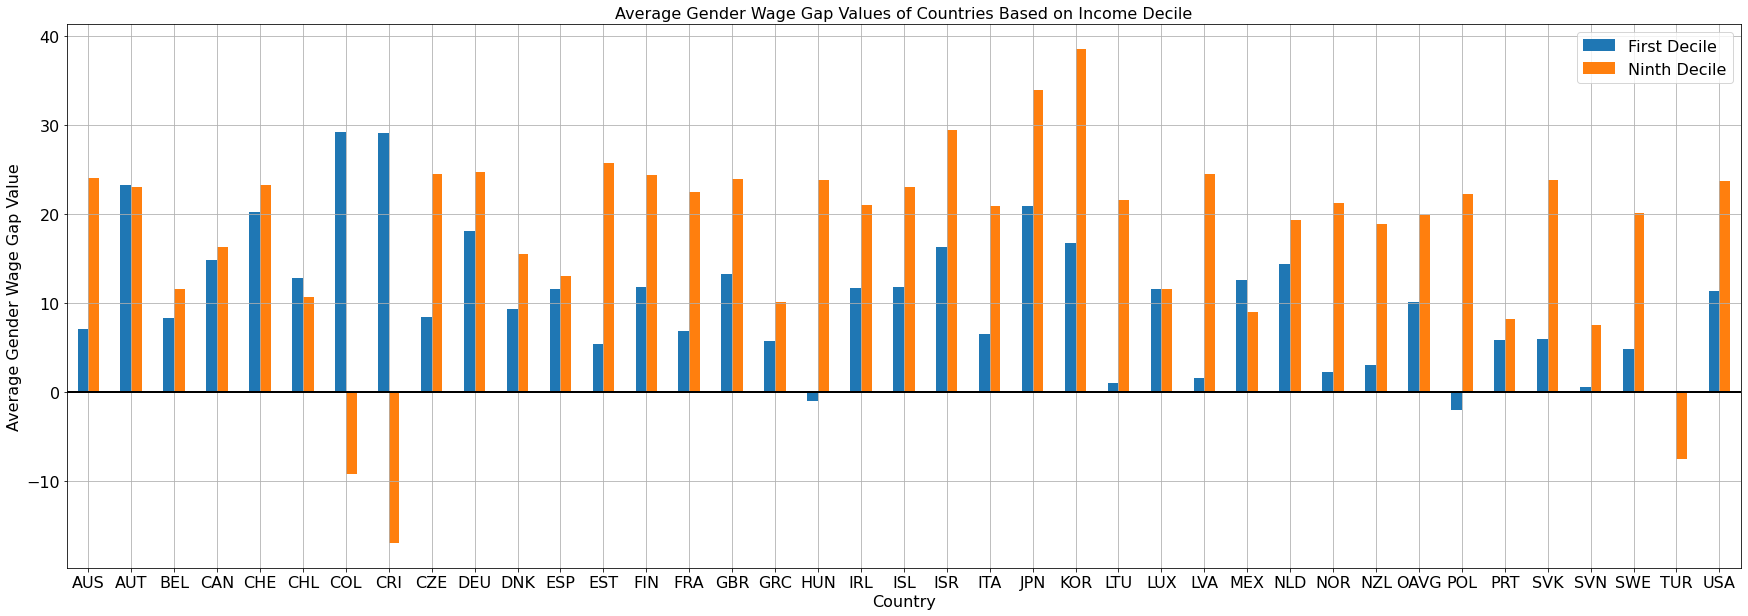

In [6]:
# Run the create_bar_graph() function
create_bar_graph()